# Spam filter Life Cycle of the Project
###This notebook written by [me](https://github.com/vassert32) completely in English for my soft skills and for understanding by foreign users.
Notebook presents a step-by-step guide to building an efficient SMS spam classification model using the SMS Spam Collection dataset.


---

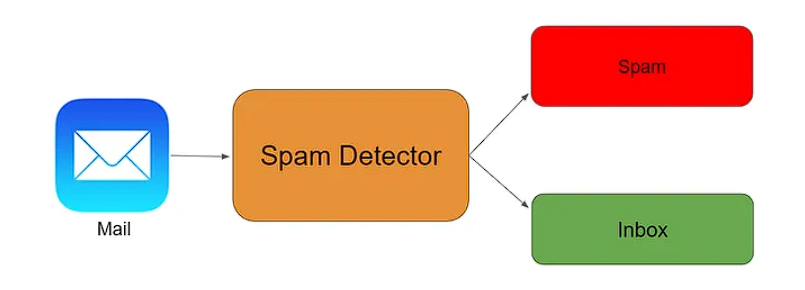

---

Dataset 1: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset

Dataset 2: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset



# Imports

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import collections
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix

from PIL import Image

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 1. Data Loading and cleaning

In [ ]:
!git clone 'https://github.com/vassert32/spam_filter_life_cycle'

Cloning into 'spam_filter_life_cycle'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 56 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 2.61 MiB | 6.12 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
df=pd.read_csv("/content/spam_filter_life_cycle/data/spam.csv", encoding='latin1') # read the data with encoding since there are special or latin characters
df.head(20) # check head

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
5,spam,FreeMsg Hey there darling it's been 3 week's n...,NaN,NaN,NaN
6,ham,Even my brother is not like to speak with me. ...,NaN,NaN,NaN
7,ham,As per your request 'Melle Melle (Oru Minnamin...,NaN,NaN,NaN
8,spam,WINNER!! As a valued network customer you have...,NaN,NaN,NaN
9,spam,Had your mobile 11 months or more? U R entitle...,NaN,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [ ]:
# drop unnamed columns
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'], inplace=True)

In [ ]:
# rename columns
df.columns = ['target','text']

In [ ]:
# create columns of length of message text
df['message_len'] = df['text'].apply(lambda x: len(x.split(' ')))
df.head()

,target,text,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


In [ ]:
max(df['message_len'])

171

In [ ]:
df.describe(include='all')

,target,text,message_len
count,5572,5572,5572.000000
unique,2,5169,NaN
top,ham,"Sorry, I'll call later",NaN
freq,4825,30,NaN
mean,NaN,NaN,15.606784
std,NaN,NaN,11.422465
min,NaN,NaN,1.000000
25%,NaN,NaN,7.000000
50%,NaN,NaN,12.000000
75%,NaN,NaN,23.000000


# 2. EDA

In [ ]:
balance_counts = df.groupby('target')['target'].agg('count').values
balance_counts

array([4825,  747])

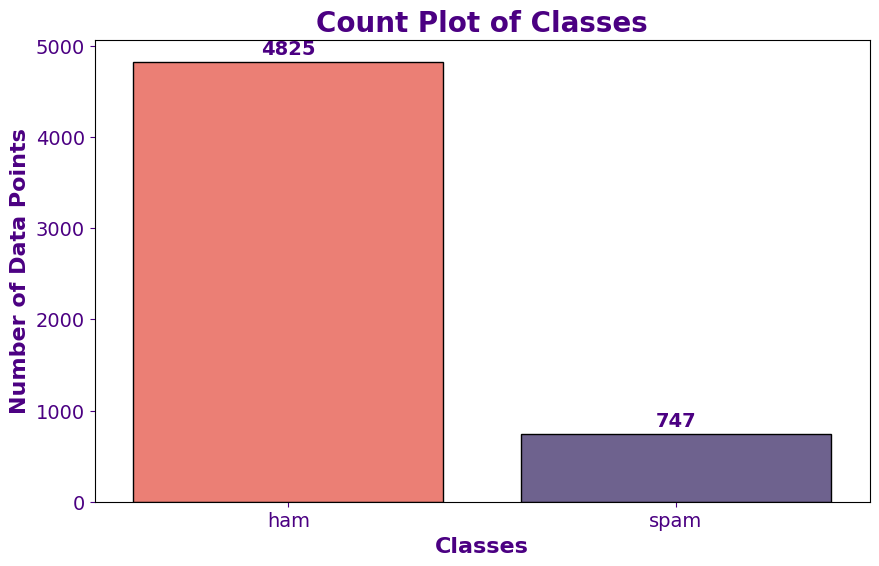

In [ ]:
palette = ["#FF6F61", "#6B5B95"] # colors

plt.figure(figsize=(10, 6))

# creating countplot
fg = sns.countplot(x=df["target"], palette=palette, edgecolor="black")

# titles and labels
fg.set_title("Count Plot of Classes", color="#4B0082", fontsize=20, fontweight='bold')
fg.set_xlabel("Classes", color="#4B0082", fontsize=16, fontweight='bold')
fg.set_ylabel("Number of Data Points", color="#4B0082", fontsize=16, fontweight='bold')

# tick params
fg.tick_params(axis='x', colors='#4B0082', labelsize=14)
fg.tick_params(axis='y', colors='#4B0082', labelsize=14)

# add labels on top of bars
for p in fg.patches:
    fg.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                color="#4B0082", fontsize=14, fontweight='bold')


plt.show()

In [ ]:
values = df['target'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100

print('percentage of 0 :' ,percentage_0)
print('percentage of 1 :' ,percentage_1)

percentage of 0 : 86.59368269921033
percentage of 1 : 13.406317300789663


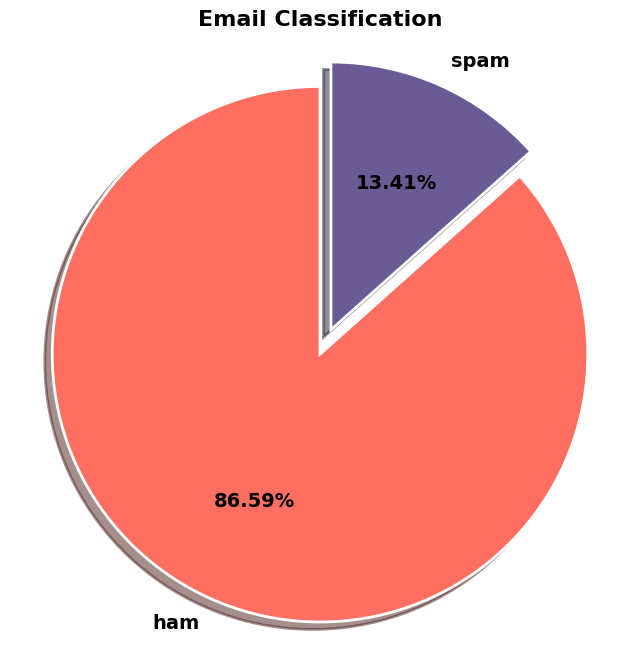

In [ ]:
palette = ["#FF6F61", "#6B5B95"]


# define the explode parameter to create a gap between slices
explode = (0, 0.1)  # Explode the second slice (spam) by 10%

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('00000')

# pie plot with custom params
wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=palette,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,  # Apply the explode parameter
    shadow=True  # Add shadow
)
# text properties
for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

ax.set_title('Email Classification', fontsize=16, fontweight='bold')

ax.axis('equal')

plt.show()

**We can clearly see how our data is imbalanced.**

---

  target  message_len
0    ham    14.323938
1   spam    23.892905


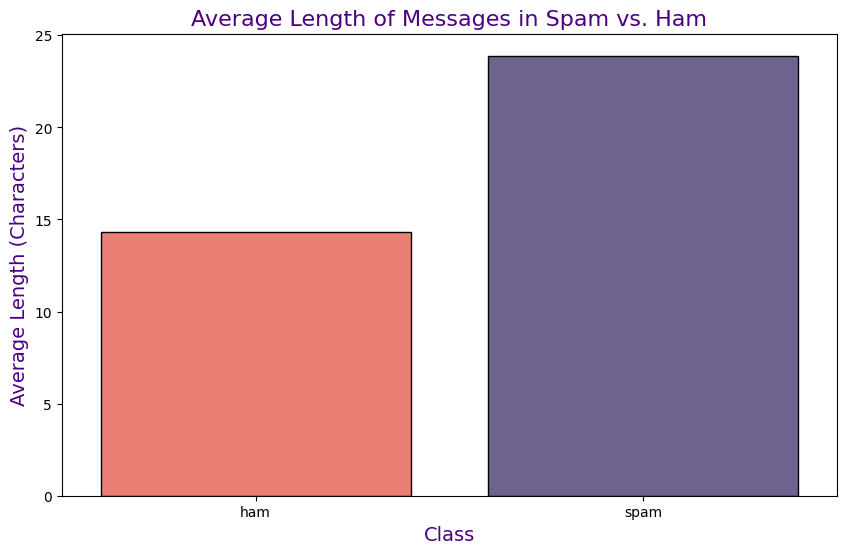

In [ ]:
palette = ["#FF6F61", "#6B5B95"]

# average lenght by grouping messages
average_length = df.groupby('target')['message_len'].mean().reset_index()
print(average_length)
# count plot of avg lenght
plt.figure(figsize=(10, 6))
sns.barplot(x='target', y='message_len', data=average_length, palette=palette, edgecolor='black')
plt.title('Average Length of Messages in Spam vs. Ham', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Average Length (Characters)', fontsize=14, color='#4B0082')
plt.show()

**Average length of spam message is bigger than ham message.** (almost double)*

---

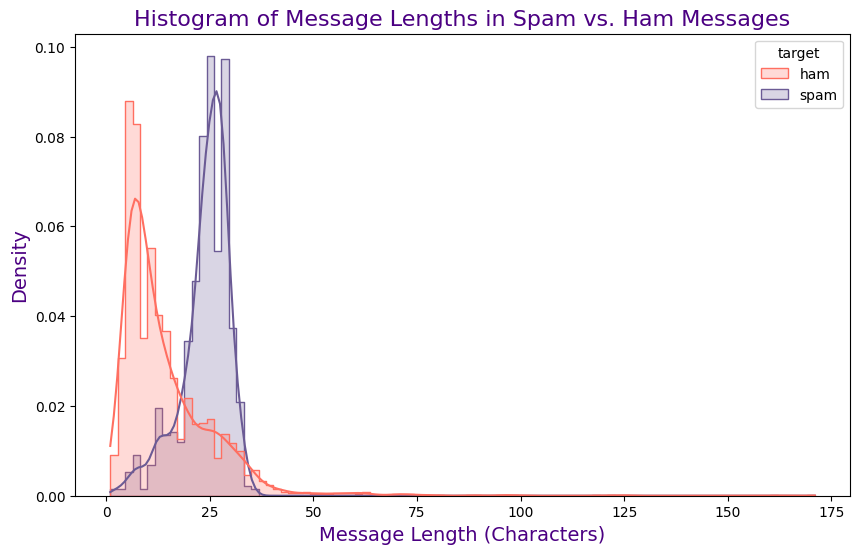

In [ ]:
# histogram plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='message_len', hue='target', palette=palette, element='step', stat='density', common_norm=False, kde=True)
plt.title('Histogram of Message Lengths in Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Message Length (Characters)', fontsize=14, color='#4B0082')
plt.ylabel('Density', fontsize=14, color='#4B0082')
plt.show()

In [ ]:
df.loc[df['message_len'].idxmax()].target

'ham'

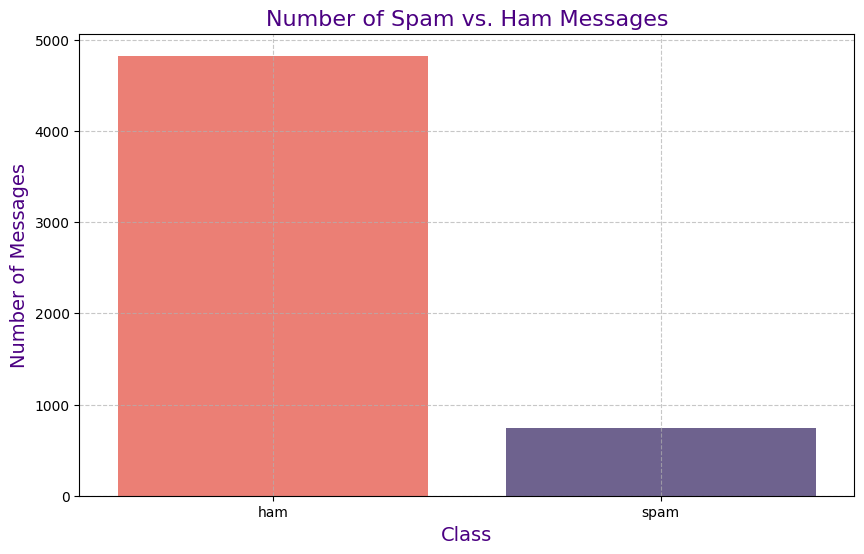

In [ ]:
# countplot
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=df, palette=palette)
plt.title('Number of Spam vs. Ham Messages', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Number of Messages', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

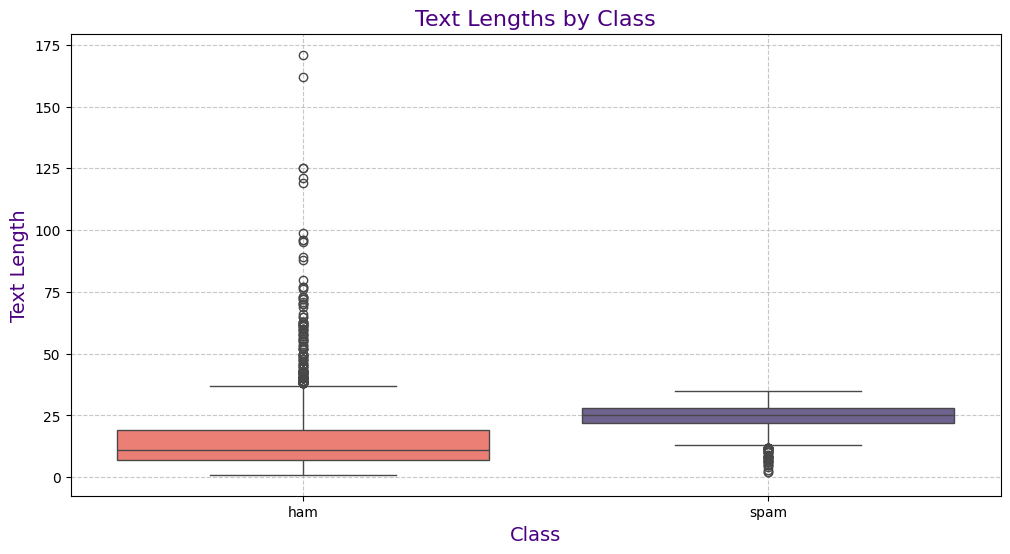

In [ ]:
# boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='message_len', data=df, palette=palette)
plt.title('Text Lengths by Class', fontsize=16, color='#4B0082')
plt.xlabel('Class', fontsize=14, color='#4B0082')
plt.ylabel('Text Length', fontsize=14, color='#4B0082')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**All plots showing the difference between these two statements.**

-----------

***Word clouds***

In [ ]:
# getting only spam messages and concat to 1 sequence
spam_texts = ' '.join(df[df['target'] == 'spam']['text'])
ham_texts = ' '.join(df[df['target'] == 'ham']['text'])
all_texts = ' '.join(df['text'])

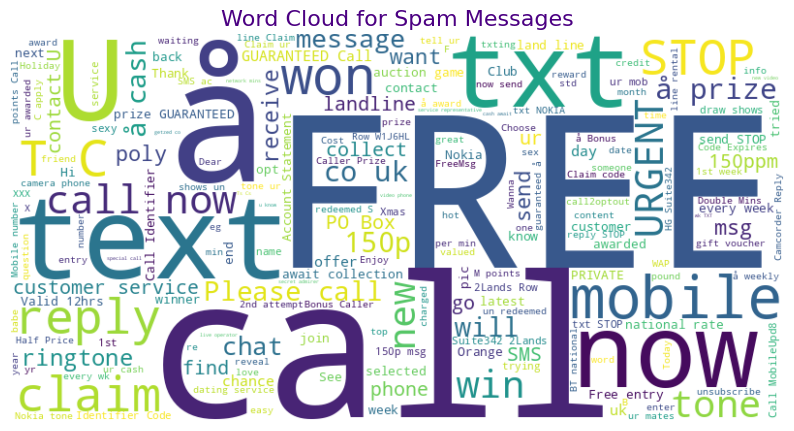

In [ ]:
# generate a spam word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(spam_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages', fontsize=16, color='#4B0082')
plt.show()

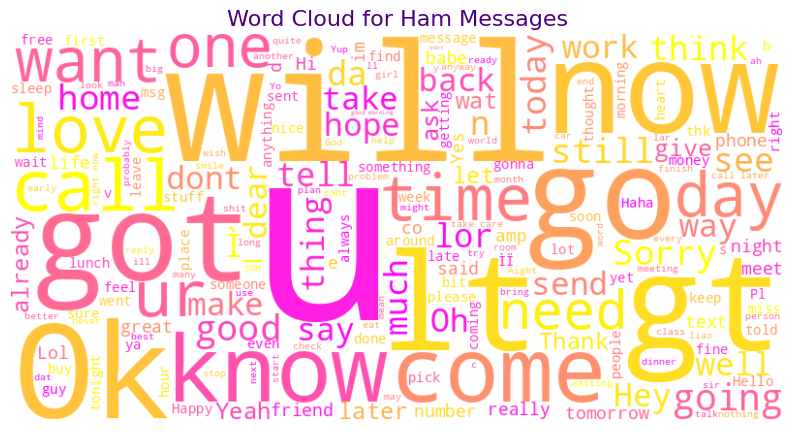

In [ ]:
# generate a ham word cloud
plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='spring').generate(ham_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages', fontsize=16, color='#4B0082')
plt.show()

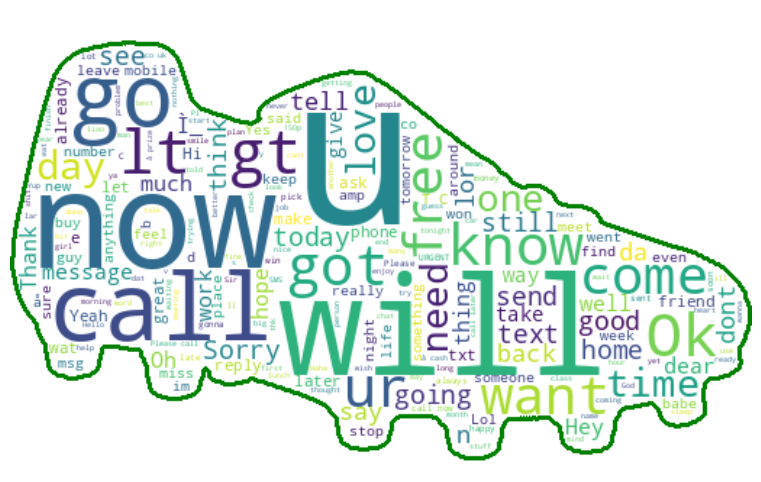

<Figure size 640x480 with 0 Axes>

In [ ]:
mask_image = np.array(Image.open('/content/spam_filter_life_cycle/data/butsa.png'))

plt.figure(figsize=(10, 6))

wc = WordCloud(width=1000, height=500, background_color="white", max_words=2000, mask=mask_image, contour_width=2, contour_color='green')

# generate word cloud
wc.generate(all_texts)

# store to file
wc.to_file('/content/spam_filter_life_cycle/data/cloud.png')

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
plt.show()

---

***Common words by group***

In [ ]:
def most_common_group(target, palette):
    words = ' '.join(df[df['target'].isin(target)]['text'])

    words_tokens = nltk.word_tokenize(words)

    # remove stop words and non-alphabetic tokens
    stop_words = set(stopwords.words('english'))
    filtered_words = [word.lower() for word in words_tokens if word.isalpha() and word.lower() not in stop_words]

    # frequency of most common words
    word_freq = collections.Counter(filtered_words)
    most_common_words = word_freq.most_common(10)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts), palette=palette, edgecolor='black')
    plt.title('Top 10 Most Common Words in Spam Messages', fontsize=16, color='#4B0082')
    plt.xlabel('Words', fontsize=14, color='#4B0082')
    plt.ylabel('Frequency', fontsize=14, color='#4B0082')
    plt.xticks(rotation=45)
    plt.show()

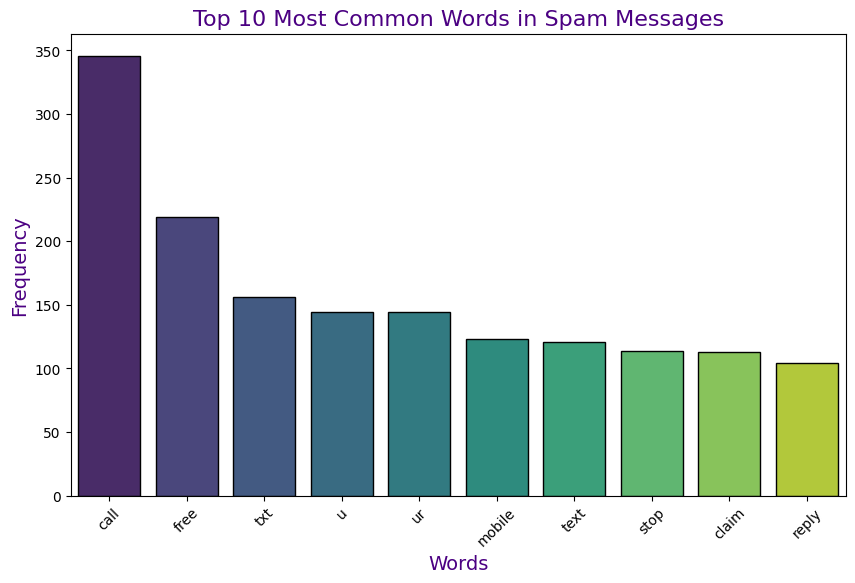

In [ ]:
most_common_group(['spam'], 'viridis')

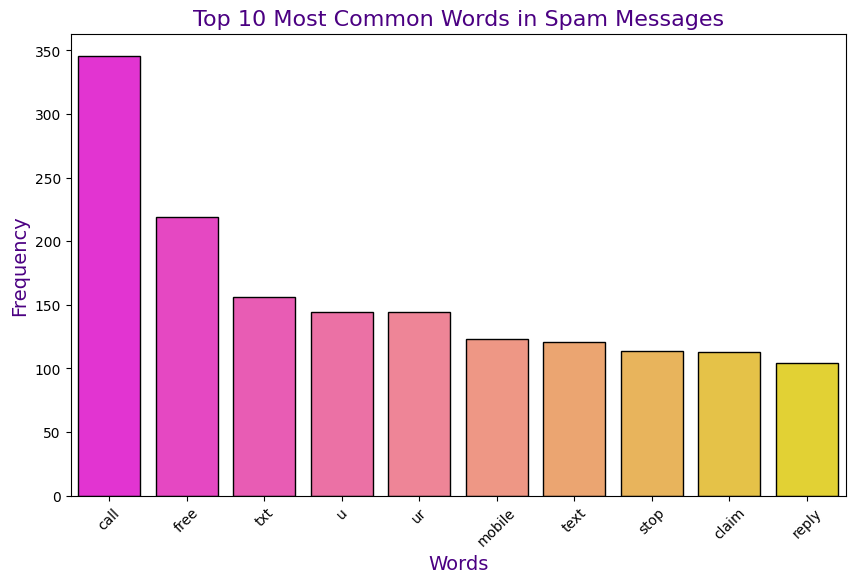

In [ ]:
most_common_group(['spam'], 'spring')

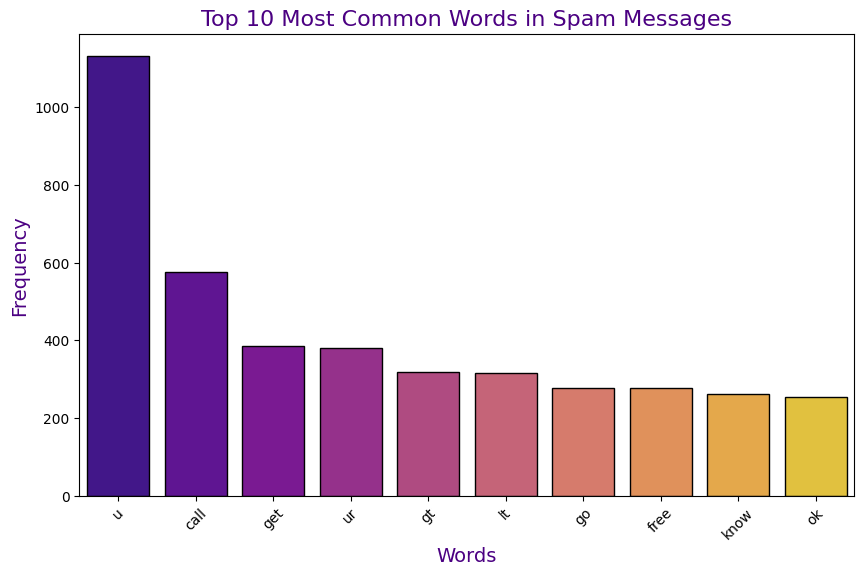

In [ ]:
most_common_group(['spam', 'ham'], 'plasma')

---

# 3. Preprocessing

---
## **NLP Text Preprocessing:**


*   **CLEANING TEXT**
*   **TOKENIZATION**
*   **REMOVING STOPWORDS**
*   **LEMMATIZATION**

---


In [ ]:
# drop outliers
df = df[(df["message_len"]<350)]
df.shape

(5572, 3)

In [ ]:
print(*df["text"][:2], sep = "\n")

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...


---
## **Cleaning text**
The computer doesn’t understand the text. for the computer, it is just a cluster of symbols. To further process the data we need to make the data cleaner.

* In the first step we **extract only the alphabetic characters** by this we are removing punctuation and numbers.
* In the next step, we are **converting** all the characters into **lowercase**.

This text will be then used in further procrssing

In [ ]:
# cleaning function
def cleaning_text(text):
    sms = re.sub('[^a-zA-Z]', ' ', text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["cleaned_text"] = df["text"].apply(cleaning_text)

print(*df["cleaned_text"][:3], sep = "\n")

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s


---
## **Tokenizing**
Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.

In [ ]:
# tokenizing
df["token_text"]=df.apply(lambda row: nltk.word_tokenize(row["cleaned_text"]), axis=1)

print(*df["token_text"][:1])

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']


---
## **Removing stopwords**
Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP.

In [ ]:
# removing stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["no_sw_text"] = df["token_text"].apply(remove_stopwords)

print(*df["no_sw_text"][:1])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']


---
##**Lemmatization**

**Stemming** is the process of getting the root form of a word. Stem or root is the part to which inflectional affixes are added. The stem of a word is created by removing the prefix or suffix of a word. It goes back to the etymology of the word. Languages evolve over time. Many different languages branch into each other; for example, English is a derivative of Latin. Thus, stemming a word takes it back to the root word.

**Lemmatization** also converts a word to its root form. However, the difference is that lemmatization ensures that the root word belongs to the language one is dealing with, in our case it is English. If we use lemmatization the output would be in English.

**Stemming algorithms**

There are several stemming algorithms implemented in NLTK Python library:

1. PorterStemmer uses Suffix Stripping to produce stems. PorterStemmer is known for its simplicity and speed. Notice how the PorterStemmer is giving the root (stem) of the word "cats" by simply removing the 's' after cat. This is a suffix added to cat to make it plural. But if you look at 'trouble', 'troubling' and 'troubled' they are stemmed to 'trouble' because PorterStemmer algorithm does not follow linguistics rather a set of 05 rules for different cases that are applied in phases (step by step) to generate stems. This is the reason why PorterStemmer does not often generate stems that are actual English words. It does not keep a lookup table for actual stems of the word but applies algorithmic rules to generate stems. It uses the rules to decide whether it is wise to strip a suffix.
2. One can generate its own set of rules for any language that is why Python nltk introduced SnowballStemmers that are used to create non-English Stemmers!
3. LancasterStemmer (Paice-Husk stemmer) is an iterative algorithm with rules saved externally. One table containing about 120 rules indexed by the last letter of a suffix. On each iteration, it tries to find an applicable rule by the last character of the word. Each rule specifies either a deletion or replacement of an ending. If there is no such rule, it terminates. It also terminates if a word starts with a vowel and there are only two letters left or if a word starts with a consonant and there are only three characters left. Otherwise, the rule is applied, and the process repeats.

In [ ]:
lemmatizer = WordNetLemmatizer()

# lemmatize string
def lemmatize_word(text):
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

df["lemm_text"] = df["no_sw_text"].apply(lemmatize_word)

print(*df["lemm_text"][:1])

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']


In [ ]:
corpus= []
for i in df["lemm_text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
corpus[:1]

['go jurong point crazy available bugis n great world la e buffet cine get amore wat']

---
##**Vectorization**
**TF-IDF** in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.

**Term Frequency** (TF) = (Frequency of a term in the document)/(Total number of terms in documents) **Inverse Document Frequency**(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.

Steps in the Vectorizing:

Creating a corpus of lemmatized text
Converting the corpus in vector form
Label Encoding the classes in Target
Note: So far we have been stalking up columns in our data for the purpose of explanation

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

In [ ]:
label_encoder = LabelEncoder()
df["target"] = label_encoder.fit_transform(df["target"])

---

#**Model Buiding**

In [ ]:
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Steps involved in the Model Building

1. Setting up features and target as X and y
2. Splitting the testing and training sets
3. Build a pipeline of model for four different classifiers.

    *   Naïve Bayes
    *   RandomForestClassifier

    *   Support Vector Machines
    *   KNeighborsClassifier


4. Fit all the models on training data
5. Get the cross-validation on the training set for all the models for accuracy

In [ ]:
classificators = [MultinomialNB(),
                  RandomForestClassifier(),
                  SVC(),
                  KNeighborsClassifier()]

for cls in classificators:
    cls.fit(X_train, y_train)

In [ ]:
models = ['NaiveBayes', 'RandomForest', 'SVC', 'KNeighbours']

for i, model in enumerate(classificators):
    print(models[i], cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10).mean())

NaiveBayes 0.8995254182754181
RandomForest 0.9479407979407979
SVC 0.931813063063063
KNeighbours 0.8798101673101673


---
# Evaluating models

##**Accuracy report**

In [ ]:
# function for getting metrics table
def cross_table(classifiers, X_test, y_test):
    precision =[]
    recall =[]
    f1_sc = []
    accuracy = []

    index = []

    for i in classifiers:
        pred_test = i.predict(X_test)

        prec_s = precision_score(y_test, pred_test)
        recal_s = recall_score(y_test, pred_test)
        f1_s = f1_score(y_test, pred_test)
        accuracy_s = accuracy_score(y_test, pred_test)

        precision.append(prec_s)
        recall.append(recal_s)
        f1_sc.append(f1_s)
        accuracy.append(accuracy_s)

        index.append(type(i).__name__)

    data = {'Precision':precision,
            'Recall':recall,
            'F1score':f1_sc,
            'Accuracy':accuracy}

    res = pd.DataFrame(data, index=index)
    return res

In [ ]:
# tf-idf metrics table for classifiers
res_tfidf = cross_table(classificators, X_test, y_test)
res_tfidf

,Precision,Recall,F1score,Accuracy
MultinomialNB,0.990991,0.733333,0.842912,0.963229
RandomForestClassifier,1.000000,0.833333,0.909091,0.977578
SVC,0.992063,0.833333,0.905797,0.976682
KNeighborsClassifier,1.000000,0.400000,0.571429,0.919283


## **Confusion Matrix**

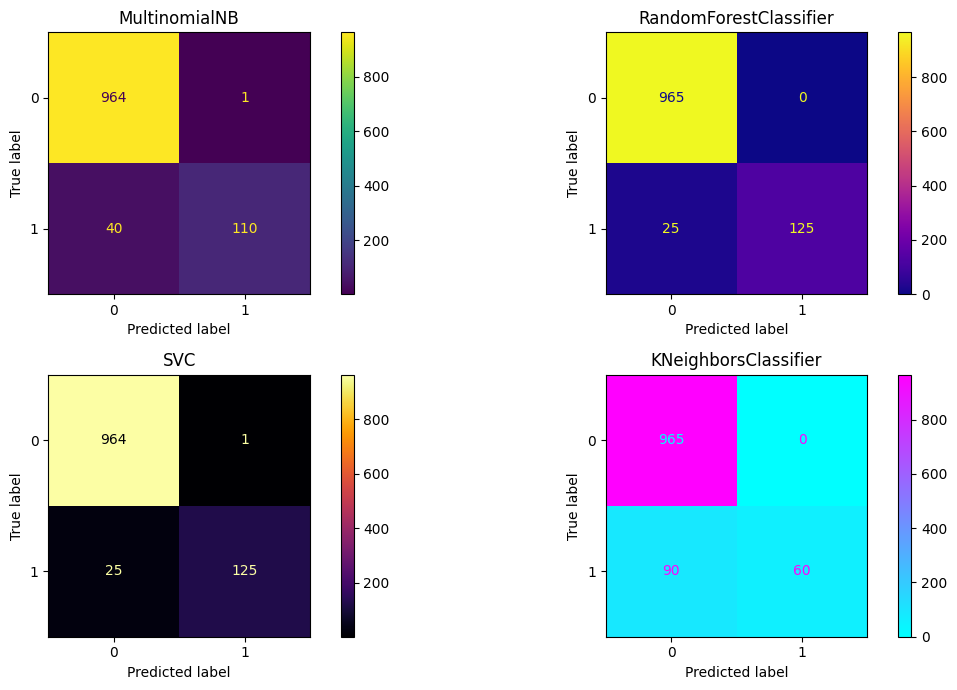

In [ ]:
colors = ['viridis', 'plasma', 'inferno', 'cool']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7))
for cl, ax, c in zip(classificators, axes.flatten(), colors):
    cm = confusion_matrix(y_test, cl.predict(X_test))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=c)
    ax.title.set_text(type(cl).__name__)

plt.tight_layout()
plt.show()

The results from the confusion matrices indicate that both RandomForestClassifier and SVC perform well across both classes, particularly with a high level of accuracy in predicting the majority class. MultinomialNB, while performing reasonably, struggles with correctly identifying the minority class, leading to a higher number of false negatives. KNeighborsClassifier, although accurate for the majority class, has difficulty handling the minority class, resulting in more classification errors. Overall, RandomForestClassifier and SVC show stronger and more balanced performance, while MultinomialNB and KNeighborsClassifier exhibit weaknesses, especially when dealing with class imbalance.

---

#***ADDITION*** : **comparison of vectorization**

## **Word2Vec vectorization**

**Word2Vec** is a popular word embedding technique that converts words into continuous vector representations based on their context in large corpora. It uses neural networks to map words into a high-dimensional space where words with similar meanings are positioned closer together. Word2Vec operates in two main models: ***Continuous Bag of Words (CBOW)***, which predicts a word based on its context, and ***Skip-gram***, which predicts the context from a given word. This method efficiently captures semantic relationships between words, making it useful for tasks like text classification and similarity detection.

In [ ]:
!pip install gensim

In [ ]:
from gensim.models import Word2Vec

# Обучение модели Word2Vec
model = Word2Vec(df['lemm_text'], vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
def get_word2vec_embeddings(message, model):
    embedding_matrix = []
    for word in message:
        if word in model.wv:
            embedding_matrix.append(model.wv[word])
        else:
            embedding_matrix.append(np.zeros(model.vector_size))
    if embedding_matrix:
        return np.mean(embedding_matrix, axis=0)
    else:
        return np.zeros(model.vector_size)

In [ ]:
X_word2vec = np.array([get_word2vec_embeddings(msg, model) for msg in df['lemm_text']])

###Model testing

In [ ]:
y = df['target']
# splitting data for w2v
X_train, X_test, y_train, y_test = train_test_split(X_word2vec, y, test_size=0.2, random_state=42)

In [ ]:
classificators_w2v = [RandomForestClassifier(),
                  SVC(),
                  KNeighborsClassifier()]

for cls in classificators_w2v:
    cls.fit(X_train, y_train)

In [ ]:
models_w2v = ['RandomForest', 'SVC', 'KNeighbours']

for i, model in enumerate(classificators_w2v):
    print(models_w2v[i], cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10).mean())

RandomForest 0.9497747747747747
SVC 0.8654681467181469
KNeighbours 0.9300353925353926


####Accuracy report

In [ ]:
res_w2v = cross_table(classificators_w2v, X_test, y_test)
res_w2v

,Precision,Recall,F1score,Accuracy
RandomForestClassifier,0.953125,0.813333,0.877698,0.969507
SVC,0.000000,0.000000,0.000000,0.865471
KNeighborsClassifier,0.770701,0.806667,0.788274,0.941704


##**Bert vectorization**

**BERT** (Bidirectional Encoder Representations from Transformers) is a powerful transformer-based model that generates context-aware embeddings for words. Unlike traditional models, BERT is bidirectional, meaning it considers both the left and right context of a word simultaneously, allowing for a deeper understanding of word meaning. BERT is pre-trained on large datasets and can be fine-tuned for specific tasks such as text classification or question answering. It captures complex linguistic features and relationships, making it highly effective for tasks requiring deep contextual understanding.

---

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# using BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
def get_bert_embeddings(tokens, model, tokenizer, max_length=128):
    if not tokens or len(tokens) == 0:  # empty tonen list
        return np.zeros(model.config.hidden_size)
    text = " ".join(tokens) # tokens to sentence
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs)
    #  meaning hidden states for getting const len vector
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


In [ ]:
X_bert = np.array([get_bert_embeddings(tokens, model, tokenizer) for tokens in df['lemm_text']])

###Model testing

In [ ]:
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X_bert, y, test_size=0.2, random_state=42)

In [ ]:
classificators_bert = [RandomForestClassifier(),
                       SVC(),
                       KNeighborsClassifier()]

for cls in classificators_bert:
    cls.fit(X_train, y_train)

####Accuracy report

In [ ]:
models_bert = ['RandomForest', 'SVC', 'KNeighbours']

for i, model in enumerate(classificators_bert):
    print(models_bert[i], cross_val_score(model, X_test, y_test, scoring='accuracy', cv=10).mean())

RandomForest 0.9551158301158301
SVC 0.9704070141570142
KNeighbours 0.9453104890604889


In [ ]:
res_bert = cross_table(classificators_bert, X_test, y_test)

In [ ]:
res_bert

,Precision,Recall,F1score,Accuracy
RandomForestClassifier,0.991453,0.773333,0.868914,0.968610
SVC,0.964286,0.900000,0.931034,0.982063
KNeighborsClassifier,0.836364,0.920000,0.876190,0.965022


In [ ]:
res_tfidf

,Precision,Recall,F1score,Accuracy
MultinomialNB,0.990991,0.733333,0.842912,0.963229
RandomForestClassifier,1.000000,0.833333,0.909091,0.977578
SVC,0.992063,0.833333,0.905797,0.976682
KNeighborsClassifier,1.000000,0.400000,0.571429,0.919283


In [ ]:
res_w2v

,Precision,Recall,F1score,Accuracy
RandomForestClassifier,0.953125,0.813333,0.877698,0.969507
SVC,0.000000,0.000000,0.000000,0.865471
KNeighborsClassifier,0.770701,0.806667,0.788274,0.941704
